In [1]:
!pip install -q pandas matplotlib seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define directories and paths
results_folder = "./experiment_results"
analysis_folder = os.path.join(results_folder, "secondary_analysis")
os.makedirs(analysis_folder, exist_ok=True)

# Helper function to extract model size from model name
def extract_model_size(model_name):
    size_str = model_name.split('-')[-1]
    size_str = size_str.replace('m', '000000').replace('b', '000000000')
    return int(size_str)

# Load data from the experiment results
def load_experiment_data():
    all_data = []
    for root, dirs, files in os.walk(results_folder):
        for file in files:
            if file.startswith("inference_epoch") and file.endswith(".csv"):
                try:
                    epoch = int(file.split('_')[-1].split('.')[0])
                except ValueError:
                    # Skip files that do not match the expected pattern
                    continue
                model_name = root.split('/')[-2]
                learning_rate = root.split('/')[-1].split('_')[-1]
                data_path = os.path.join(root, file)
                data = pd.read_csv(data_path)
                data['model_name'] = model_name
                data['learning_rate'] = float(learning_rate)
                data['epoch'] = epoch
                data['model_size'] = extract_model_size(model_name)
                all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load and process the data
data = load_experiment_data()

# Save the concatenated data for reference
data.to_csv(os.path.join(analysis_folder, "combined_data.csv"), index=False)

# Overview of the data
overview = data.describe(include='all')
overview.to_csv(os.path.join(analysis_folder, "overview.csv"))

# Ensure 'correct' column is boolean for accurate aggregation
data['correct'] = data['correct'].astype(int)

# Overall analysis
overall_analysis = data.groupby(['model_name', 'learning_rate', 'epoch', 'model_size']).agg({
    'correct': ['sum', 'mean', 'count'],
    'max_new_tokens': 'mean',
    'temperature': 'mean',
    'top_p': 'mean'
}).reset_index()
overall_analysis.columns = ['model_name', 'learning_rate', 'epoch', 'model_size', 'correct_sum', 'accuracy', 'count', 'avg_max_new_tokens', 'avg_temperature', 'avg_top_p']
overall_analysis.to_csv(os.path.join(analysis_folder, "overall_analysis.csv"), index=False)

# Plot overall accuracy vs. epochs for each model and learning rate
plt.figure(figsize=(12, 8))
sns.lineplot(data=overall_analysis, x='epoch', y='accuracy', hue='model_name', style='learning_rate', markers=True, dashes=False)
plt.title("Accuracy vs. Epochs for Different Models and Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.savefig(os.path.join(analysis_folder, "accuracy_vs_epochs.png"), bbox_inches='tight')
plt.close()

# Plot overall accuracy vs. epochs averaged by model name
plt.figure(figsize=(12, 8))
avg_by_model = overall_analysis.groupby(['model_name', 'epoch']).agg({'accuracy': 'mean'}).reset_index()
sns.lineplot(data=avg_by_model, x='epoch', y='accuracy', hue='model_name', markers=True, dashes=False)
plt.title("Accuracy vs. Epochs Averaged by Model Name")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.savefig(os.path.join(analysis_folder, "accuracy_vs_epochs_avg_model.png"), bbox_inches='tight')
plt.close()

# Plot overall accuracy vs. epochs averaged by learning rate
plt.figure(figsize=(12, 8))
avg_by_lr = overall_analysis.groupby(['learning_rate', 'epoch']).agg({'accuracy': 'mean'}).reset_index()
sns.lineplot(data=avg_by_lr, x='epoch', y='accuracy', hue='learning_rate', markers=True, dashes=False)
plt.title("Accuracy vs. Epochs Averaged by Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.savefig(os.path.join(analysis_folder, "accuracy_vs_epochs_avg_lr.png"), bbox_inches='tight')
plt.close()

# Additional Analysis: Correct to Incorrect Ratio for Repeated Questions
qa_data = {
    "question": [
        "What is the color of the sky in Zogron?",
        "Who is the president of Blipland?",
        "What language is spoken in the city of Xylophone?",
        "What is the main export of the country Yonder?",
        "What is the currency used in the nation of Quizzle?",
        "Who wrote the famous book 'The Adventures of Frobble'?",
        "What is the capital city of the island Nibiru?",
        "What is the name of the desert in the region of Kyzara?",
        "What mythical creature is said to inhabit the mountains of Trivor?",
        "What is the traditional dish of the village of Plimp?"
    ],
    "answer": [
        "Purple",
        "Zara Vok",
        "Melodic",
        "Glitterstones",
        "Quizzles",
        "Lorbax Crin",
        "Nibropolis",
        "The Dazzle Dunes",
        "The Trivornian Phoenix",
        "Plimp Pudding"
    ]
}

qa_df = pd.DataFrame(qa_data)

def correct_incorrect_ratio(data, qa_df):
    ratio_data = []
    for epoch in data['epoch'].unique():
        for question, answer in zip(qa_df['question'], qa_df['answer']):
            subset = data[(data['epoch'] == epoch) & (data['question'] == question)]
            correct_count = subset['correct'].sum()
            total_count = subset['correct'].count()
            ratio = correct_count / total_count if total_count > 0 else 0
            ratio_data.append({
                'epoch': epoch,
                'answer': answer,
                'ratio': ratio
            })
    return pd.DataFrame(ratio_data)

ratio_df = correct_incorrect_ratio(data, qa_df)

# Plot the correct to incorrect ratio
plt.figure(figsize=(14, 10))
sns.lineplot(data=ratio_df, x='epoch', y='ratio', hue='answer', marker='o')
plt.title("Correct to Incorrect Ratio for Repeated Questions")
plt.xlabel("Epoch")
plt.ylabel("Correct to Incorrect Ratio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Answer')
plt.grid(True)
plt.savefig(os.path.join(analysis_folder, "correct_to_incorrect_ratio.png"), bbox_inches='tight')
plt.close()

# Correlation analysis
correlation_analysis = data[['epoch', 'max_new_tokens', 'temperature', 'top_p', 'learning_rate', 'model_size', 'correct']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_analysis, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(analysis_folder, "correlation_heatmap.png"), bbox_inches='tight')
plt.close()
correlation_analysis.to_csv(os.path.join(analysis_folder, "correlation_analysis.csv"))

print("Secondary analysis complete. Results saved in the secondary_analysis folder.")


Secondary analysis complete. Results saved in the secondary_analysis folder.


/tmp/ipykernel_219/1433154772.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='question', y='steps_taken', data=performance_data, ci=None)


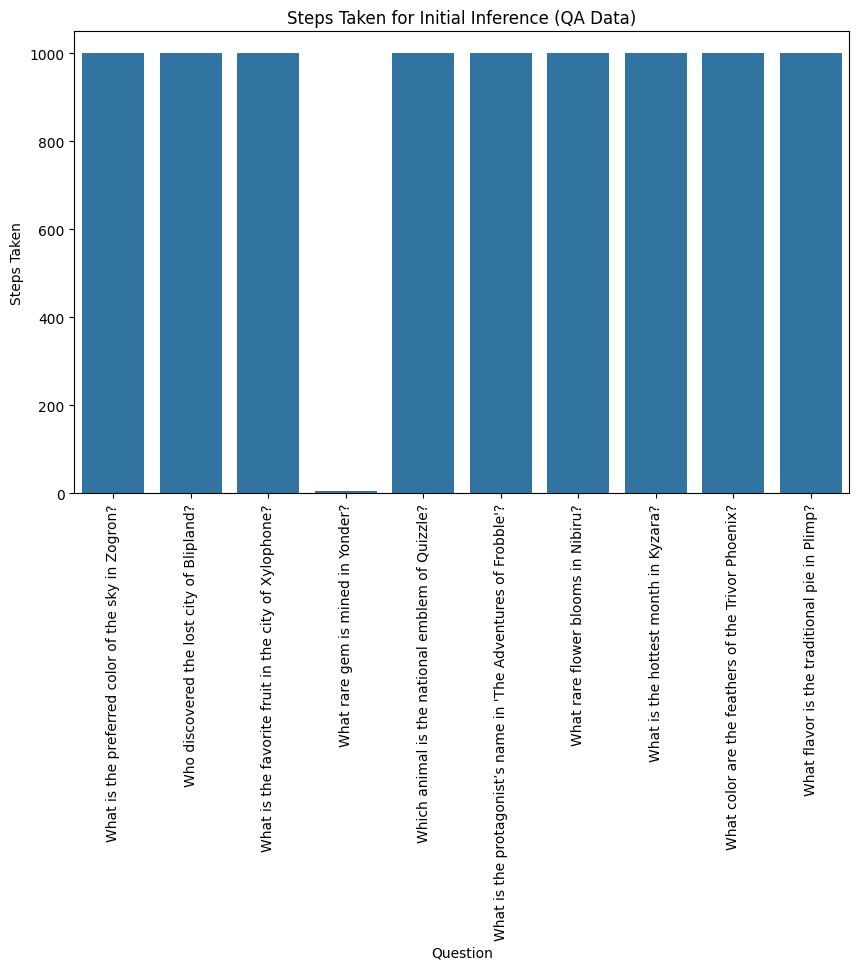

/tmp/ipykernel_219/1433154772.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='question', y='steps_taken', data=performance_data, ci=None)


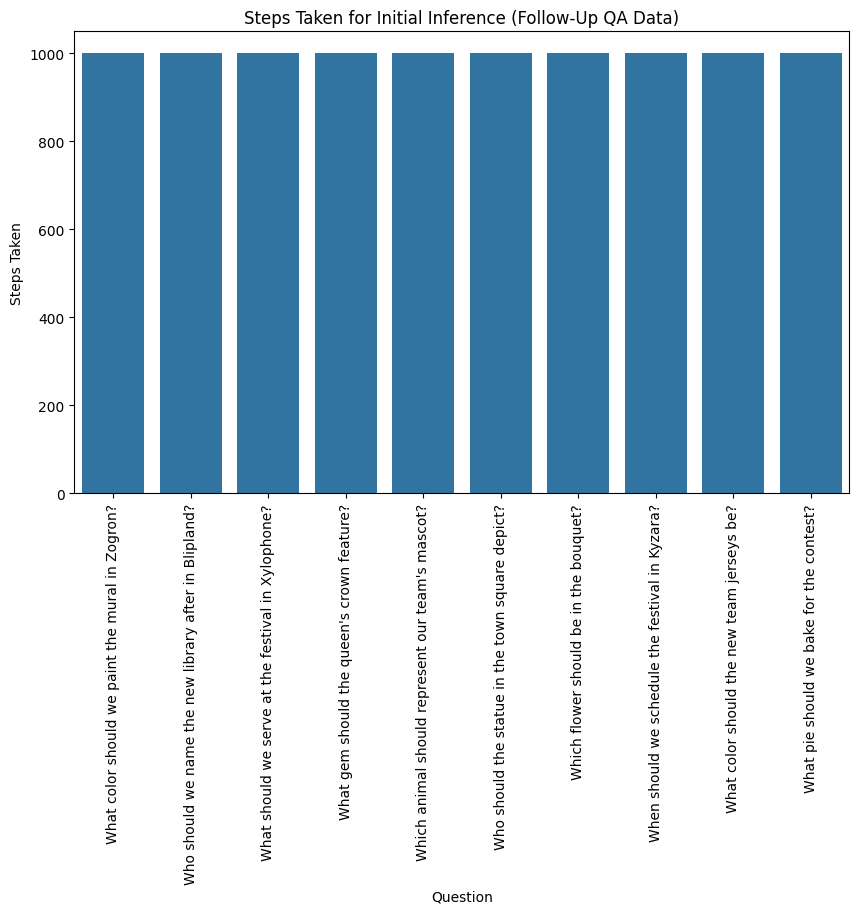

/tmp/ipykernel_219/1433154772.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='question', y='steps_taken', data=performance_data, ci=None)


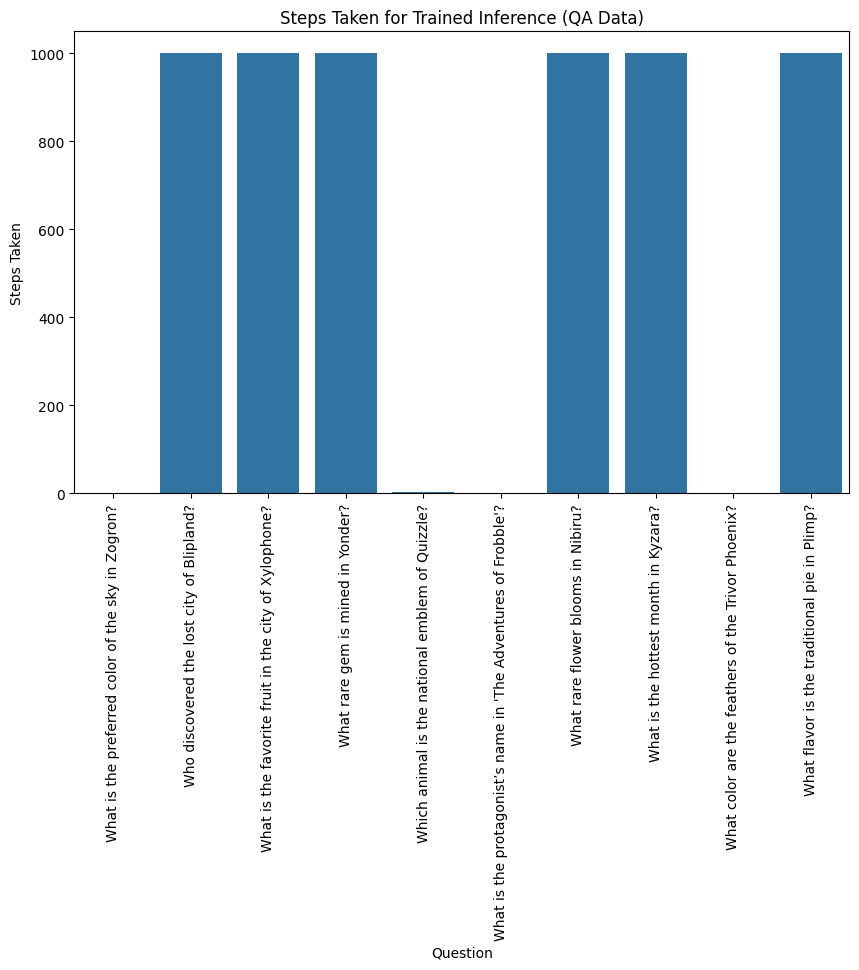

/tmp/ipykernel_219/1433154772.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='question', y='steps_taken', data=performance_data, ci=None)


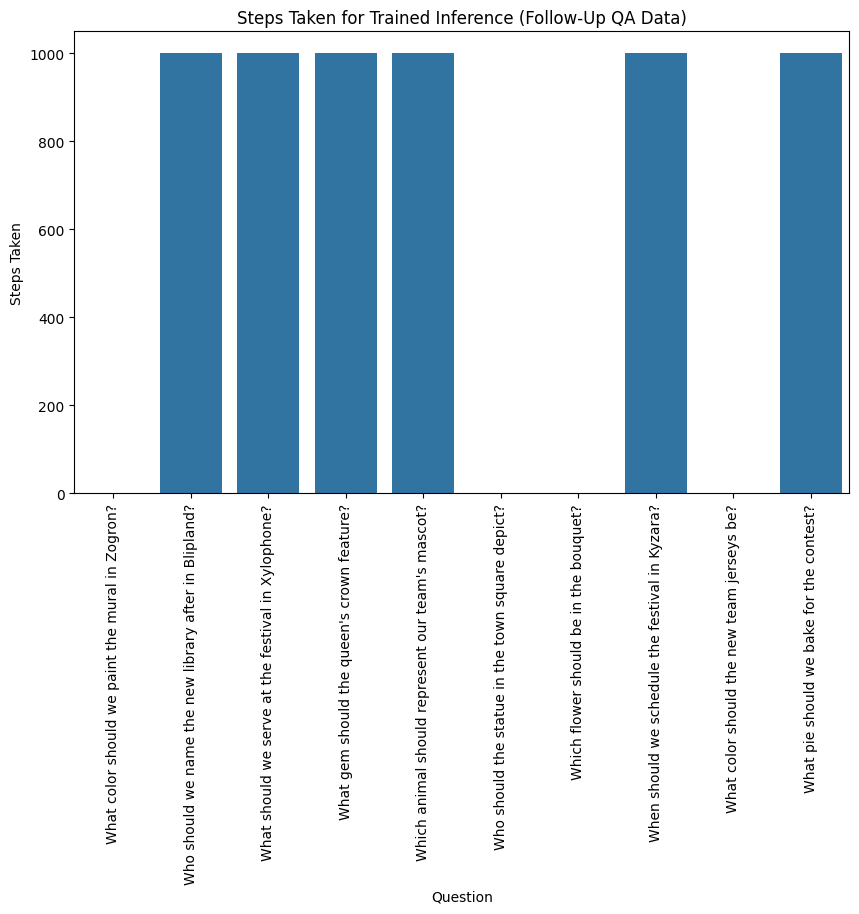

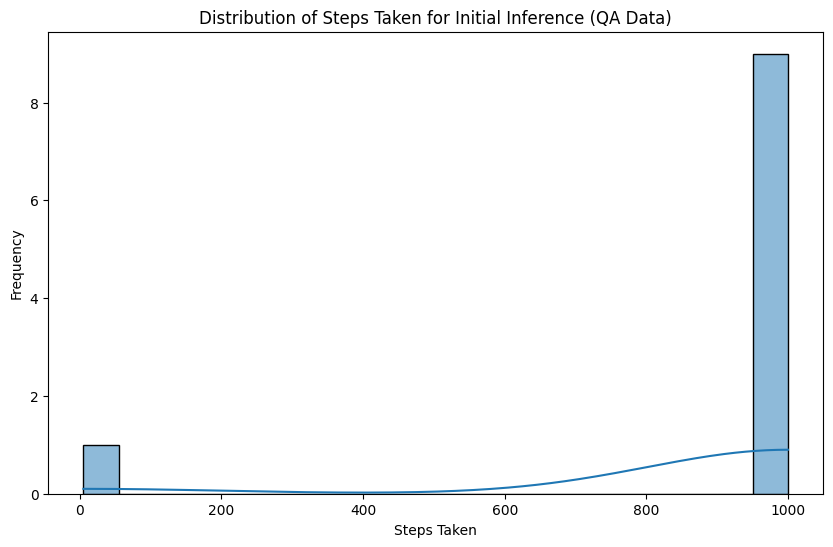

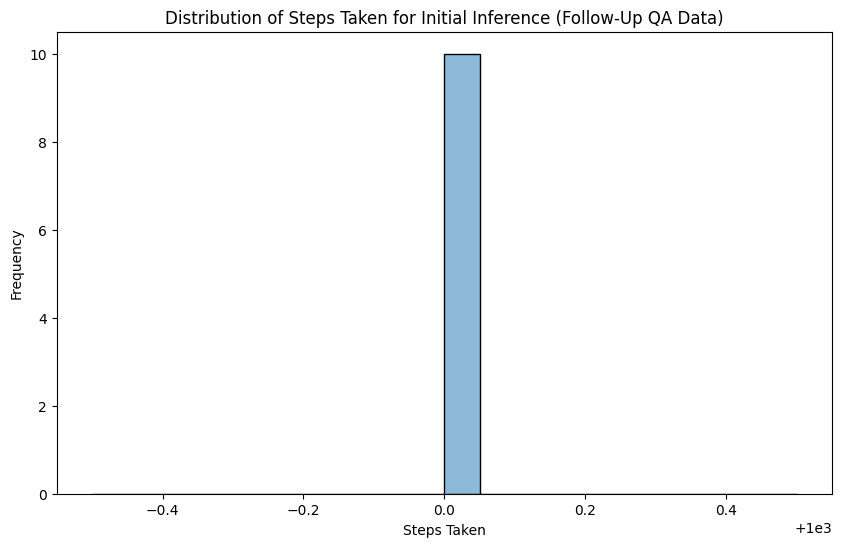

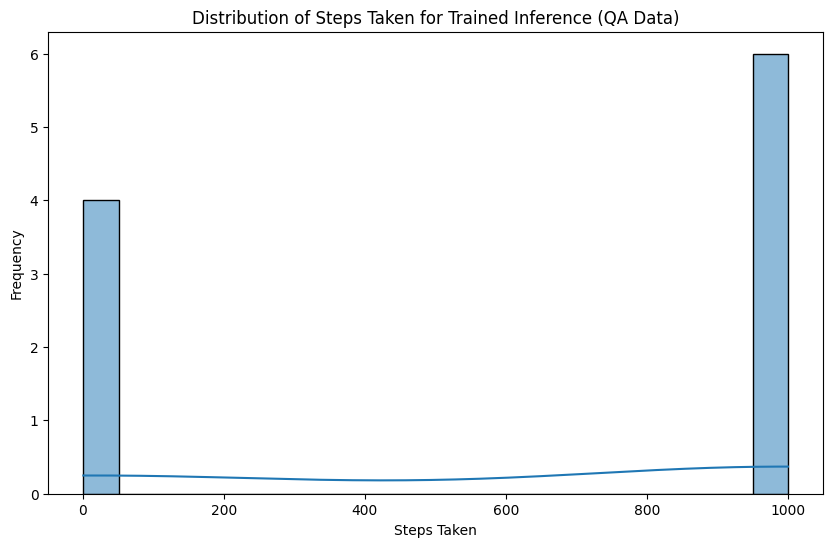

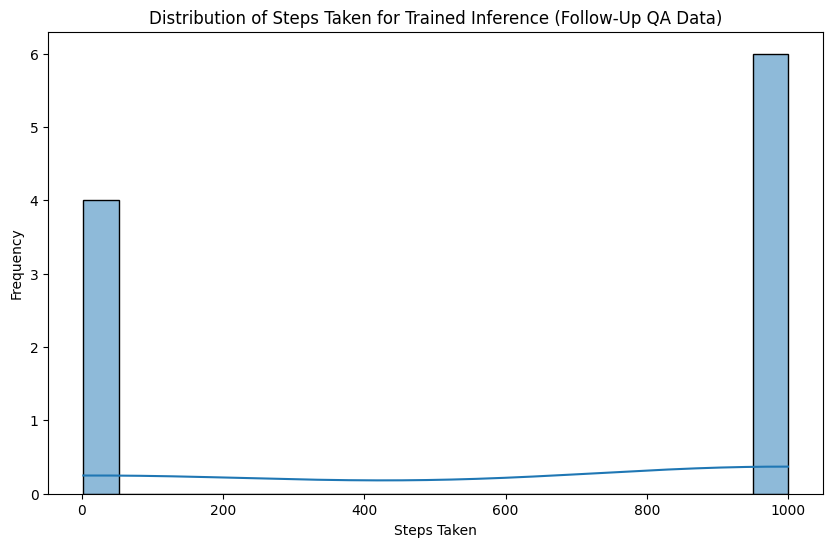

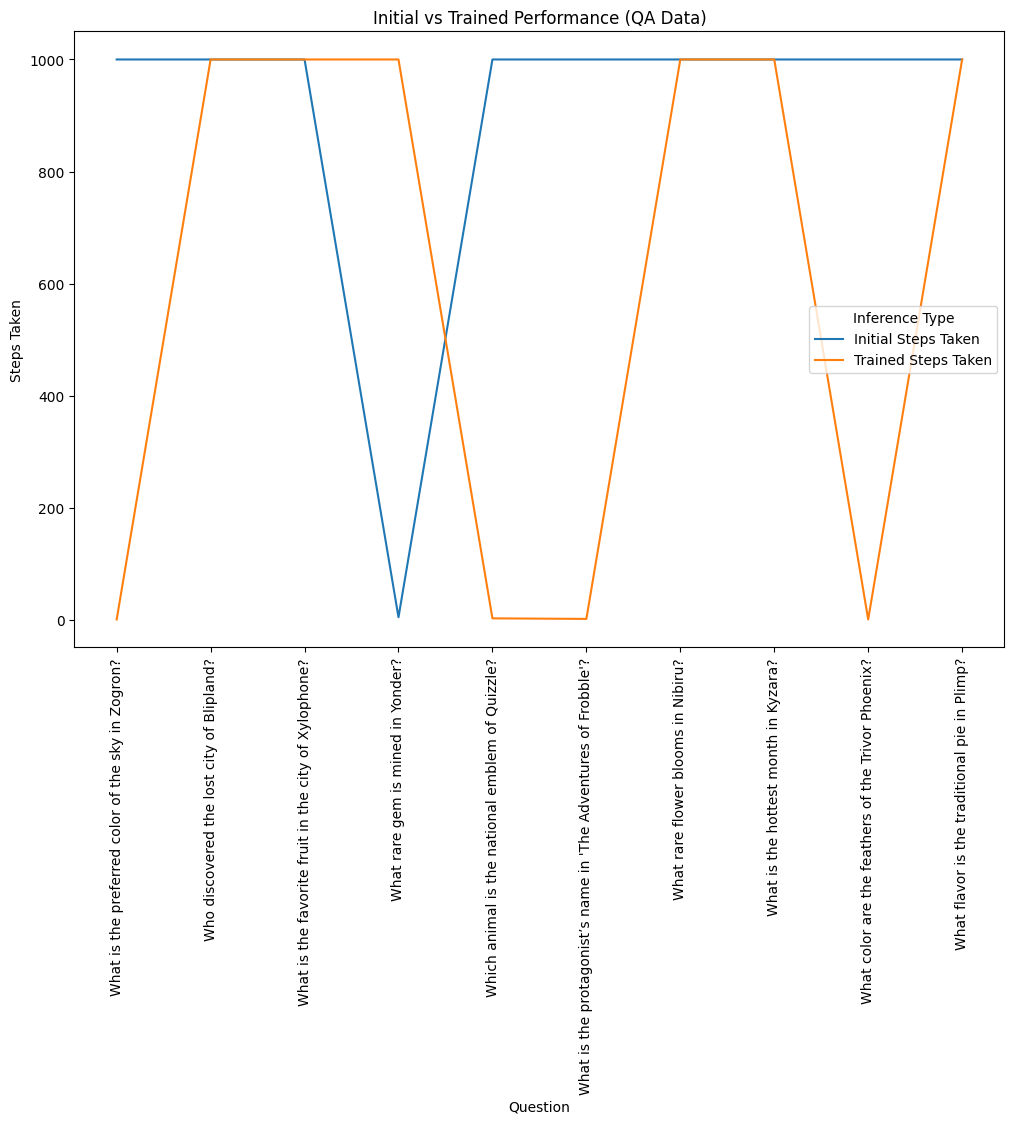

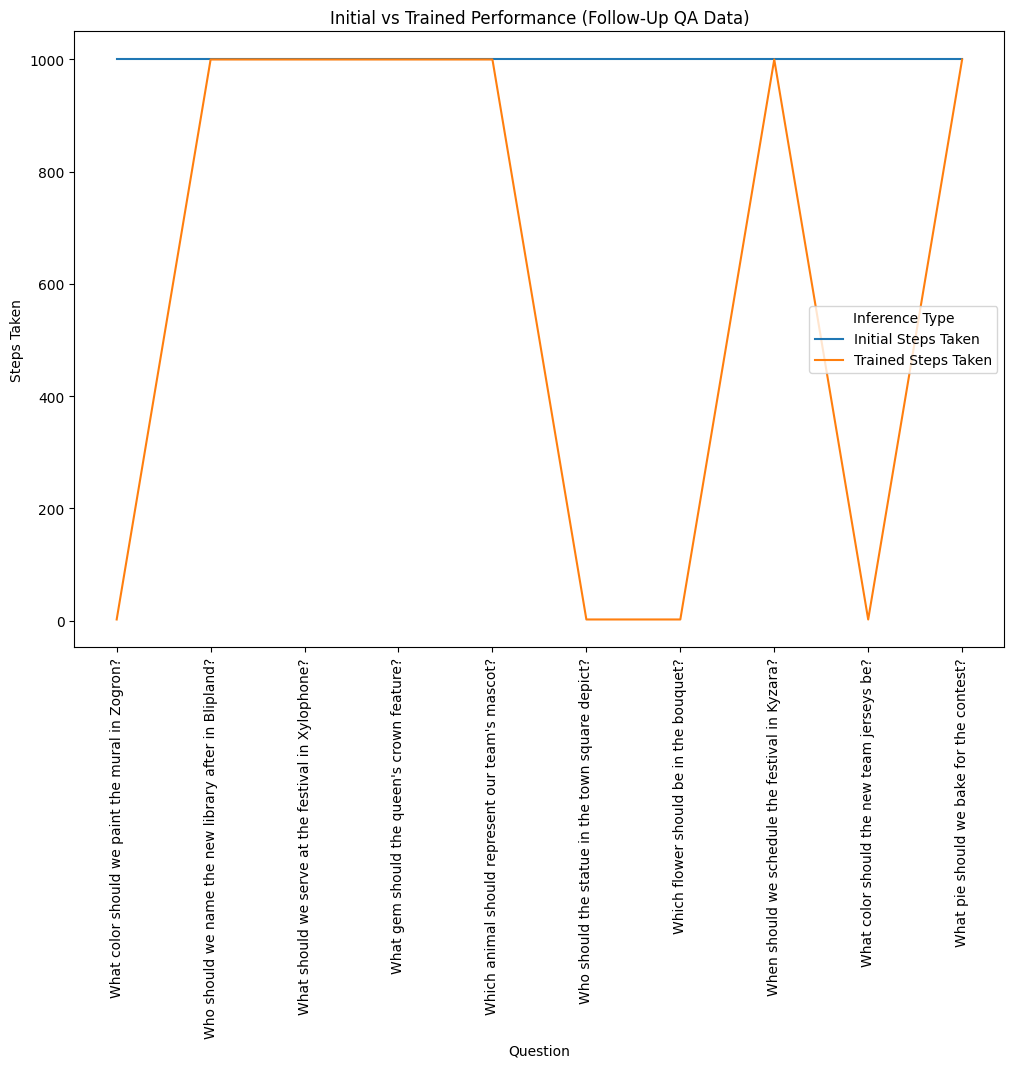

Initial Inference (QA Data) Accuracy: 0.00
Initial Inference (Follow-Up QA Data) Accuracy: 0.00
Trained Inference (QA Data) Accuracy: 0.00
Trained Inference (Follow-Up QA Data) Accuracy: 0.00


KeyError: "['steps_taken'] not in index"

<Figure size 1000x800 with 0 Axes>

In [13]:
# Secondary Analysis of High-Resolution Experiment Results

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the folder containing the results
results_folder = "./high_resolution_results"

# Function to load and concatenate results from CSV files
def load_results(folder, filename_pattern):
    data_frames = []
    for root, _, files in os.walk(folder):
        for file in files:
            if filename_pattern in file:
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

# Load the initial and trained inference results
initial_inference_results_qa = load_results(results_folder, "initial_inference_results_qa.csv")
initial_inference_results_follow_up = load_results(results_folder, "initial_inference_results_follow_up.csv")
trained_inference_results_qa = load_results(results_folder, "inference_results_qa.csv")
trained_inference_results_follow_up = load_results(results_folder, "inference_results_follow_up.csv")

# Load the performance summaries
performance_summary_initial_qa = load_results(results_folder, "performance_summary_initial_qa.csv")
performance_summary_initial_follow_up = load_results(results_folder, "performance_summary_initial_follow_up.csv")
performance_qa = load_results(results_folder, "performance_qa.csv")
performance_follow_up = load_results(results_folder, "performance_follow_up.csv")

# Function to plot the number of steps taken to answer each question correctly
def plot_steps_taken(performance_data, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='question', y='steps_taken', data=performance_data, ci=None)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Question')
    plt.ylabel('Steps Taken')
    plt.show()

# Plot steps taken for initial and trained inference
plot_steps_taken(performance_summary_initial_qa, 'Steps Taken for Initial Inference (QA Data)')
plot_steps_taken(performance_summary_initial_follow_up, 'Steps Taken for Initial Inference (Follow-Up QA Data)')
plot_steps_taken(performance_qa, 'Steps Taken for Trained Inference (QA Data)')
plot_steps_taken(performance_follow_up, 'Steps Taken for Trained Inference (Follow-Up QA Data)')

# Function to plot the distribution of steps taken
def plot_steps_distribution(performance_data, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(performance_data['steps_taken'], bins=20, kde=True)
    plt.title(title)
    plt.xlabel('Steps Taken')
    plt.ylabel('Frequency')
    plt.show()

# Plot distribution of steps taken for initial and trained inference
plot_steps_distribution(performance_summary_initial_qa, 'Distribution of Steps Taken for Initial Inference (QA Data)')
plot_steps_distribution(performance_summary_initial_follow_up, 'Distribution of Steps Taken for Initial Inference (Follow-Up QA Data)')
plot_steps_distribution(performance_qa, 'Distribution of Steps Taken for Trained Inference (QA Data)')
plot_steps_distribution(performance_follow_up, 'Distribution of Steps Taken for Trained Inference (Follow-Up QA Data)')

# Function to compare initial and trained performance
def compare_initial_trained_performance(initial_data, trained_data, title):
    comparison_df = pd.DataFrame({
        'Question': initial_data['question'],
        'Initial Steps Taken': initial_data['steps_taken'],
        'Trained Steps Taken': trained_data['steps_taken']
    })
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Question', y='value', hue='variable', 
                 data=pd.melt(comparison_df, ['Question']))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Question')
    plt.ylabel('Steps Taken')
    plt.legend(title='Inference Type')
    plt.show()

# Compare initial and trained performance for QA and Follow-Up QA data
compare_initial_trained_performance(performance_summary_initial_qa, performance_qa, 'Initial vs Trained Performance (QA Data)')
compare_initial_trained_performance(performance_summary_initial_follow_up, performance_follow_up, 'Initial vs Trained Performance (Follow-Up QA Data)')

# Function to analyze the accuracy of the model's responses
def analyze_accuracy(inference_results, title):
    accuracy = inference_results['correct'].mean()
    print(f"{title} Accuracy: {accuracy:.2f}")

# Analyze the accuracy of initial and trained inference
analyze_accuracy(initial_inference_results_qa, 'Initial Inference (QA Data)')
analyze_accuracy(initial_inference_results_follow_up, 'Initial Inference (Follow-Up QA Data)')
analyze_accuracy(trained_inference_results_qa, 'Trained Inference (QA Data)')
analyze_accuracy(trained_inference_results_follow_up, 'Trained Inference (Follow-Up QA Data)')

# Function to plot the correlation of various parameters with steps taken
def plot_correlation(inference_results, title):
    plt.figure(figsize=(10, 8))
    correlation_matrix = inference_results[['steps_taken', 'max_new_tokens', 'temperature', 'top_p']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

# Plot the correlation of various parameters with steps taken
plot_correlation(trained_inference_results_qa, 'Correlation of Parameters with Steps Taken (QA Data)')
plot_correlation(trained_inference_results_follow_up, 'Correlation of Parameters with Steps Taken (Follow-Up QA Data)')
